In [30]:
%matplotlib widget
import numpy as np
import cv2
import torchio as tio
from collections import deque
import json
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import skimage.morphology as mp;
import warnings
import matplotlib as mpl

##### ImageNavigator Class

In [31]:
# Désactiver les avertissements de matplotlib
mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter("ignore", category=UserWarning)

class ImageNavigator:
    def __init__(self, data, type="slice"):
        self.data = data
        self.num_slices = data.shape[0]  # could also represent time
        self.current_index = 0

        # Initialize figure and axes
        self.fig, self.ax = plt.subplots()
        self.update_image(type)  # Call the update_image method to initialize the display
        self.ax.axis('off')

        # Add buttons for navigation
        axprev = plt.axes([0.7, 0.01, 0.1, 0.075])
        axnext = plt.axes([0.81, 0.01, 0.1, 0.075])
        self.bprev = Button(axprev, 'Previous')
        self.bnext = Button(axnext, 'Next')
        self.bprev.on_clicked(lambda event: self.prev_image(event, type))
        self.bnext.on_clicked(lambda event: self.next_image(event, type))        
        plt.show()

    def save_image(self, event):
        """Save the current image to a file."""
        filename = f'image_{self.current_index}.png'
        plt.imsave(filename, self.data[self.current_index, :, :], cmap='gray' if self.data.ndim == 3 else None)
        print(f'Saved image {filename}')

    def update_image(self, type):
        """Update the image according to the current slice index and image type."""
        
        # Effacer l'ancienne image
        self.ax.cla()  # Clear the axis
        
        # Réaffichage de l'image
        if self.data.ndim == 3:  # Handle grayscale image
            self.image = self.ax.imshow(self.data[self.current_index, :, :], cmap='gray')
        elif self.data.ndim == 4:  # Handle RGBA image
            self.image = self.ax.imshow(self.data[self.current_index, :, :, :])  # RGBA, no cmap needed
        
        self.ax.set_title(f'{type}: {self.current_index}')
        self.ax.axis('off')  # Ensure axes are turned off
        self.fig.canvas.draw()

    def prev_image(self, event, type):
        if self.current_index > 0:
            self.current_index -= 1
            self.update_image(type)

    def next_image(self, event, type):
        if self.current_index < self.num_slices - 1:
            self.current_index += 1
            self.update_image(type)

def bulk_plot(data):
    nav = ImageNavigator(data)
    return nav

In [32]:
def patient_info(patient_id):
        ''' Return a dictionary with patient information from the Info.cfg file:
            ED: int; 
            ES: int;
            Group: DCM/HCM/NOR/MINF/RV; 
            Height: float; 
            NbFrame: int;
            Weight: float;
            '''
        if int(patient_id) < 101:
            filename = f"../database/training/patient{patient_id}/Info.cfg"
        elif 100 <int(patient_id) < 151:
            image = f"../database/testing/patient{patient_id}/Info.cfg"
        else:
            print("Patient ID must be between 001 and 150.")
            return
        
        info_dict = {}
        with open(filename, 'r') as file:
            for line in file:
                key, value = line.strip().split(': ')
                if key=="ED" or key=="ES":
                    value = int(value)
                info_dict[key] = value
                #print(f'{key}: {value}')

        return info_dict

##### IRM class

In [33]:
class Irm():
    def __init__(self,patient_id):
        self.patient_id = patient_id
        self.image = tio.ScalarImage(f"../database/training/patient{patient_id}/patient{patient_id}_4d.nii.gz")

        ### Patient information ###
        self.data = self.image.data.numpy()                         # 4D image data
        self.shape = self.data.shape                                # Shape of the 4D image
        self.middle_slice = self.data.shape[-1]//2                  # Middle slice index
        self.info = patient_info(patient_id)                        # Patient information
        self.t_ED = patient_info(self.patient_id)["ED"]-1           # End-diastolic time index
        self.t_ES = patient_info(self.patient_id)["ES"]-1           # End-systolic time index

        ### Seed points ###
        self.initial_seed_point = None                              # Initial seed point
        self.seed_points = {}                                       # Seed points for each layer index

        self.images_processed = []

        ### Set of slices and times for Navigation ###
        self.set_of_slices = {}                                     # key: time index, value: array of slices
        self.set_of_times = {}                                      #key: layer index, value: array of times
        for k in range(self.data.shape[0]):
            self.set_of_slices[k] = np.array([self.data[k,:,:,i] for i in range(self.data.shape[3])])
        for k in range(self.data.shape[3]):
            self.set_of_times[k] = np.array([self.data[i,:,:,k] for i in range(self.data.shape[0])])

        ### Metrics ###
        self.gt1 = tio.ScalarImage(f"../database/training/patient{patient_id}/patient{patient_id}_frame01_gt.nii.gz").data.numpy()
        self.mean_dice = None

    def show_slices(self, time_index):
        """this function plots all layers of the 4D image at a specific time index"""
        nav = ImageNavigator(self.set_of_slices[time_index])
        return nav
    
    def show_times(self, layer_index):
        """this function plots all time indexes of the 4D image at a specific layer index"""
        nav = ImageNavigator(self.set_of_times[layer_index],type="time")
        return nav

##### Example of use of the IRM Class

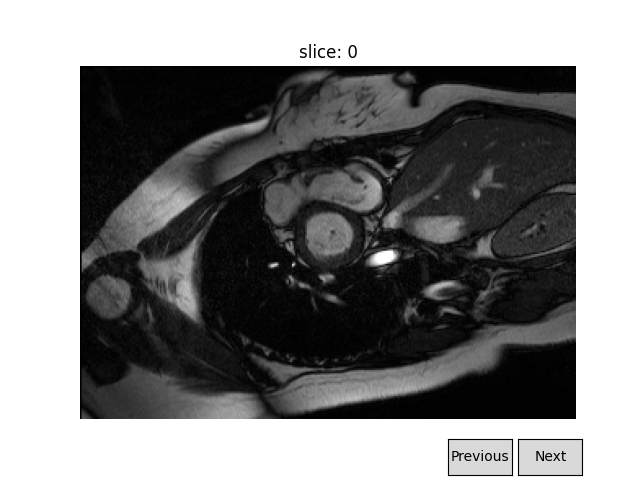

In [34]:
irm=Irm("100")
irm.show_slices(0)

##### Tools panel

In [76]:
def absolute_difference_Ed_ES(patient_id,slice_index):
    '''Return the absolute difference between the end-diastolic and end-systolic images for a given patient and slice index.'''
    if int(patient_id) < 101:
        image = tio.ScalarImage(f"../database/training/patient{patient_id}/patient{patient_id}_4d.nii.gz")
    elif 100 < int(patient_id) < 151:
        image = tio.ScalarImage(f"../database/testing/patient{patient_id}/patient{patient_id}_4d.nii.gz")
    else:
        print("Patient ID must be between 001 et 150.")
        return
    # Calculer la différence en valeurs absolues
    data = image.data.numpy()
    image1 = data[patient_info(patient_id)["ED"], :, :, slice_index]
    image2 = data[patient_info(patient_id)["ES"], :, :, slice_index]
    abs_diff = np.abs(image1 - image2)
    
    return abs_diff

def hough(closed_image, rayons_test,r_med,bar, thickness=1):
    shape = closed_image.shape
    # Initialisation de l'image d'accumulation
    ima_intens = np.zeros((len(rayons_test), shape[0], shape[1]))
    #print(f"Rayons testés : {rayons_test}")

    # Récupération des coordonnées des points d'intérêt (pixels blancs)
    points = np.column_stack(np.where(closed_image == 255))

    for i, r in enumerate(rayons_test):
        if r < 1:
            pass
        for a, b in points:
            mask = np.zeros(shape, dtype=np.uint8)
            # Tracer un cercle autour du point (b, a) avec le rayon r
            cv2.circle(mask, (b, a), r, 255, thickness)
            #ima_intens[i][mask == 255] += 1 *np.exp(-(r-r_med)**2/(2*var))
            ima_intens[i][mask == 255] += 1/(1+r/2)/(np.sqrt((a-bar[0])**2+(b-bar[1])**2)+1)

    # Trouver le maximum dans l'accumulateur
    r_ind, x, y = np.unravel_index(np.argmax(ima_intens), ima_intens.shape)
    r = rayons_test[r_ind]
    #print(f"Le rayon trouvé est : {r} et le rayon médian est : {r_med}")
    #print(f"Le centre est aux coordonnées ({x}, {y}).")
    return x, y, r

def dilate(img, region, mask):
    '''For a given binary image, a region and a mask .Return the dilated region.'''
    mask = np.array(mask)# S'assurer que le masque est un tableau numpy
    mask_shape = mask.shape
    shape = img.shape
    copy = np.zeros(shape, dtype=np.int32)
    
    # Marquer les points de la région initiale dans 'copy'
    for x, y in region:
        copy[x, y] = 1
    # Calcul de l'offset en fonction de la taille du masque
    offset_x = mask_shape[0] // 2
    offset_y = mask_shape[1] // 2

    # Appliquer le masque de dilatation
    for x, y in region:
        for i in range(mask_shape[0]):
            for j in range(mask_shape[1]):
                if mask[i, j] == 1: # Vérifier la position du masque
                    nx, ny = x + i - offset_x, y + j - offset_y
                    # Vérifier les limites de l'image
                    if 0 <= nx < shape[0] and 0 <= ny < shape[1]:
                        # Ajouter les points dilatés à 'new_region' si non déjà présents
                        if copy[nx, ny] == 0:
                            copy[nx, ny] = 1  # Marquer dans 'copy' pour éviter de repasser dessus
    new_region = np.argwhere(copy == 1).tolist()
    return new_region   

def erode(img, region, mask):
    '''For a given binary image, a region and a mask .Return the eroded region.'''
    mask = np.array(mask)  # S'assurer que le masque est un tableau numpy
    mask_shape = mask.shape
    shape = img.shape
    copy = np.zeros(shape, dtype=np.int32)
    new_region = set()  # Nouvel ensemble pour stocker la région érodée
    
    # Marquer les points de la région initiale dans 'copy'
    for x, y in region:
        copy[x, y] = 1

    # Calcul de l'offset pour centrer le masque autour de chaque point
    offset_x = mask_shape[0] // 2
    offset_y = mask_shape[1] // 2

    # Appliquer le masque d'érosion
    for x, y in region:
        erode_point = True  # On assume que le point peut rester dans la région érodée
        for i in range(mask_shape[0]):
            for j in range(mask_shape[1]):
                if mask[i, j] == 1:  # Position du masque à vérifier
                    nx, ny = x + i - offset_x, y + j - offset_y
                    # Si un voisin hors de la région est trouvé, on enlève le point
                    if not (0 <= nx < shape[0] and 0 <= ny < shape[1] and copy[nx, ny] == 1):
                        erode_point = False
                        break
            if not erode_point:
                break
        # Si tous les voisins dans le masque sont dans la région, on garde le point
        if erode_point:
            new_region.add((x, y))
    
    return new_region

def close(img, region, mask):
    '''For a given binary image, a region and a mask .Return the closed region.'''
    return erode(img, dilate(img, region, mask), mask)

def region_growing_adaptive(irm, t,x ,y ,z, threshold=20, filtered=False, nb_neighbours=8):
    '''Region growing algorithm with adaptive thresholding. Return the image in rgb and the segmented region.'''
    # Convert the image to 32-bit float format
    if filtered:
        image_32f = irm.data[t,:,:,z].astype(np.float32)
        working_set = cv2.bilateralFilter(image_32f, 15, 50, 60)
    else:
        working_set = irm.data[t,:,:,z]
    #print(f"shape of working_set : {working_set.shape}")
    initial_x,initial_y = x,y
    to_explore = [(x,y)]
    explored = []
    edge= []
    region=[(x,y)]
    image_processed = irm.data[t,:,:,z]
    while to_explore:
        if len(explored)>2500:
            to_explore = [(initial_x,initial_y)]
            explored = []
            edge= []
            region=[(initial_x,initial_y)]
            #print("Too many iterations. Threshold is too high.")
            threshold-=1
        x,y = to_explore.pop(0)
        if not -1< x < irm.data.shape[1] or not -1< y < irm.data.shape[2]:
            raise ValueError("Coordinates are out of bounds.")
        if nb_neighbours == 4:
            neighbours = [(x+1,y),(x-1,y),(x,y+1),(x,y-1)]
        elif nb_neighbours == 8:
            neighbours = [(x+1,y),(x-1,y),(x,y+1),(x,y-1), (x+1,y+1),(x-1,y-1),(x+1,y-1),(x-1,y+1)]
        for couple in neighbours:
            if couple not in explored and couple not in edge and -1<couple[0]<irm.data.shape[1] and -1<couple[1]<irm.data.shape[2]:
                if abs(working_set[x,y] -working_set[couple[0],couple[1]]) < threshold:
                    to_explore.append(couple)
                    region.append(couple)
                else:
                    edge.append(couple)
            else:
                continue 
            explored.append(couple)
    mask = [[0,1,0],[1,1,1],[0,1,0]]
    region = close(working_set,region,np.ones((8,8)))
    region = dilate(working_set,region,mask)
    region = np.array(region)
    contour = region.reshape((-1,1,2))
    hull = cv2.convexHull(contour)
    image = np.zeros((irm.shape[1], irm.shape[2], 3), dtype=np.uint8)  # Remplacez les dimensions par celles de votre image
    cv2.drawContours(image, [hull], -1, (255, 255, 255), thickness=-1)
    # Dessiner l'enveloppe convexe sur l'image
    cv2.drawContours(image, [hull], -1, (255), thickness=-1)
    np.column_stack(np.where(image > 0))
    new_region = np.column_stack(np.where(image > 0))
    region = np.array([(y, x) for x, y,z in new_region.tolist()])
    if image_processed.dtype == 'float32':
        image_processed = 255 * (image_processed - np.min(image_processed)) / (np.max(image_processed) - np.min(image_processed))
        image_processed = image_processed.astype(np.uint8)
    image_rgb = np.stack((image_processed,)*3, axis=-1)
    image_rgba = np.dstack((image_rgb, np.ones(image_rgb.shape[:2], dtype=np.uint8) * 255))
    for couple in region:
        try:
            # Extraire les valeurs RGB d'origine
            gray_value = image_rgba[couple[0], couple[1], 0]  # La valeur de gris (R = G = B)
            # Superposer un peu de vert sans écraser les valeurs de gris
            new_red = gray_value * (1 - 0.5) + 128   # Une proportion du rouge d'origine
            new_green = gray_value * (1 - 0.5)   # Mélange du vert (128) avec le gris
            new_blue = gray_value * (1 - 0.5)  # Une proportion du bleu d'origine
            
            # Mettre à jour la couleur et l'alpha
            image_rgba[couple[0], couple[1]] = [new_red, new_green, new_blue, 128]
        except:
            pass
    return image_rgba,region

def barycentre(irm, t, z, region):
    '''Return the barycentre of a region'''
    A = np.zeros((irm.data.shape[1], irm.data.shape[2]))
    
    if len(region)==0:
        raise ValueError("Region is empty, cannot compute barycentre.")
    
    for couple in region:
        try:
            y, x = couple[1], couple[0]
            A[x, y] = 1
        except:
            pass

    total_sum = np.sum(A)
    if total_sum == 0:
        raise ValueError("Sum of the binary image is zero, cannot compute barycentre.")

    x = np.sum(A * np.arange(A.shape[0]).reshape(-1, 1)) / total_sum
    y = np.sum(A * np.arange(A.shape[1]).reshape(1, -1)) / total_sum
    return (int(y), int(x))

rayon : 18
Initial seed point: (np.int64(254), np.int64(309))
Rayon: 58


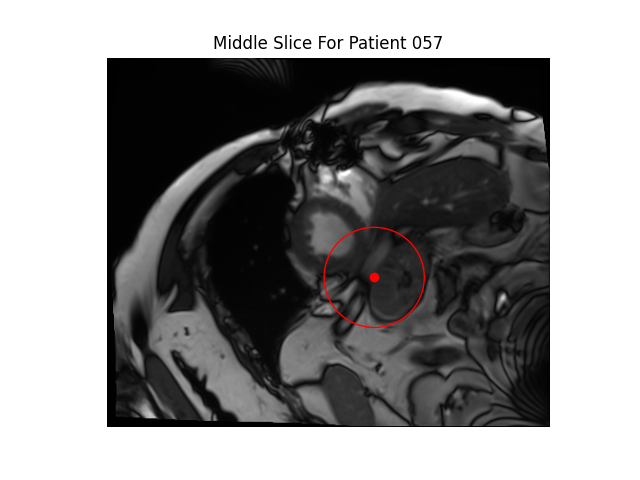

In [73]:
irm = Irm("057")
working_set = absolute_difference_Ed_ES(irm.patient_id,irm.middle_slice).astype('uint8')

std = np.std(working_set)
if std < 10:
    lowThresh = 15*std
elif 10 <= std < 26:
    lowThresh = 20*std
else:
    lowThresh = 15*std 
edges = cv2.Canny(working_set, lowThresh, 1.5*lowThresh)
L=hough(edges)
initial_seed_point = L[0],L[1]
rayon=58
print(f"Initial seed point: {initial_seed_point}")
print(f"Rayon: {rayon}")

# Plot the middle slice with the seed point and circle
plt.figure(1)
fig, ax = plt.subplots()
ax.imshow(irm.data[0,:,:,irm.middle_slice], cmap='gray')

# Plot the seed point in red
ax.plot(initial_seed_point[1], initial_seed_point[0], 'ro')

# Plot the circle in red
circle = plt.Circle((initial_seed_point[1], initial_seed_point[0]), rayon, color='r', fill=False)
ax.add_patch(circle)

plt.title('Middle Slice For Patient 057')
plt.axis('off')
plt.show()

In [79]:
def get_window(image,x,y,w=35):
    windowed = image[x-w:x+w,y-w:y+w]
    """ plt.imshow(windowed)
    plt.show() """
    return windowed

def get_barycentre(grayscale_image):
    """
    Calcule le barycentre d'une image en niveaux de gris.

    Parameters:
        grayscale_image (numpy.ndarray): Image en niveaux de gris.

    Returns:
        tuple: Coordonnées (x_barycentre, y_barycentre).
    """
    # Vérifier si l'image est vide (tous les pixels à 0)
    if np.sum(grayscale_image) == 0:
        return None

    # Créer une grille de coordonnées
    y_indices, x_indices = np.indices(grayscale_image.shape)

    # Calculer les coordonnées pondérées par l'intensité des pixels
    total_intensity = np.sum(grayscale_image)
    x_barycentre = np.sum(x_indices * grayscale_image) / total_intensity
    y_barycentre = np.sum(y_indices * grayscale_image) / total_intensity

    return y_barycentre, x_barycentre

def find_indices_within_range(lst, percent, epsilon):
    """
    Trouve les indices min et max d'une liste pour les valeurs entre percent-epsilon et percent+epsilon.
    
    :param lst: Liste de valeurs (liste ou tableau numpy).
    :param percent: Valeur centrale.
    :param epsilon: Tolérance autour de percent.
    :return: Indices minimum et maximum des éléments satisfaisant la condition, ou (None, None) si aucun trouvé.
    """
    # Définir la plage de recherche
    lower_bound = percent - epsilon
    upper_bound = percent + epsilon
    
    # Trouver les indices des éléments satisfaisant la condition
    indices = [i for i, value in enumerate(lst) if lower_bound <= value <= upper_bound]
    
    if indices:
        return min(indices), max(indices)
    else:
        return None, None  # Aucun élément trouvé dans la plage
with open('rayons_opti.json', "r") as file:
        radius_data = json.load(file)
def new_hough(irm,data=radius_data, thickness=1, show=False):
    N = irm.data.shape[-1]
    values = []
    epsilon = 0.05
    x_padd = irm.data.shape[1] / 10
    y_padd = irm.data.shape[2] / 10

    data_percents = data["x"]
    data_rayons = data["y"]

    abs = np.abs(irm.data[irm.t_ED, :, :, 0] - irm.data[irm.t_ES, :, :, 0]).astype('uint8')
    abs = cv2.bilateralFilter(abs, 3, 75, 200)
    #abs = cv2.GaussianBlur(abs, (5, 5), 0)
    working_set = abs.astype('uint8')

    x_bar, y_bar = get_barycentre(working_set)

    pixel_2 = abs.shape[0]*abs.shape[1]


    for slices in range(N):
        percent = slices / N
        #print(f"Processing percent {percent}.")

        # Récupérer les indices des rayons pertinents
        ind_min, ind_max = find_indices_within_range(data_percents, percent, epsilon)
        rayons_utiles = data_rayons[ind_min:ind_max]
        rayons_utiles = np.array(rayons_utiles)
        rayons_utiles = np.round(np.sqrt(rayons_utiles*pixel_2)).astype(int)
        #print(f"Rayons utiles : {rayons_utiles}")
        if len(rayons_utiles) == 0: 
            continue  # Ignorer si aucun rayon pertinent

        r_min, r_max = min(rayons_utiles), max(rayons_utiles) + 10
        r_mean = np.mean(rayons_utiles)
        r_median = np.median(rayons_utiles)
        variance = np.std(rayons_utiles)
        #print(variance)


        # Générer des rayons avec des pas adaptés
        rayons_test = sorted(set(range(r_min, r_max + 1, 3)) | 
                             set(range(max(r_min, int(r_mean - 2 * np.sqrt(variance))),
                                       min(r_max, int(r_mean + 2 * np.sqrt(variance))) + 1, 1)))

        # Prétraitement de l'image
        abs = np.abs(irm.data[irm.t_ED, :, :, slices] - irm.data[irm.t_ES, :, :, slices]).astype('uint8')
        abs = cv2.bilateralFilter(abs, 3, 75, 200)
        #abs = cv2.GaussianBlur(abs, (3, 3), 0)
        roi = get_window(abs, int(x_bar), int(y_bar))
        working_set = roi.astype('uint8')


        # Détection des contours avec Canny
        std = np.std(working_set)
        if std < 10:
            lowThresh = 15*std
        elif 10 <= std < 26:
            lowThresh = 20*std
        else:
            lowThresh = 15*std
        
        edges = cv2.Canny(working_set, lowThresh/1.5, lowThresh*2)
        nb_non_zero = np.count_nonzero(edges)
        while nb_non_zero < 250:
            #print(f"Slice {slices} has {nb_non_zero}pxs.")
            lowThresh = lowThresh-15
            edges = cv2.Canny(working_set, lowThresh, lowThresh*3)
            nb_non_zero = np.count_nonzero(edges)

        # Appel à hough
        x2, y2, r = hough(edges, rayons_test,r_median, (x_bar, y_bar))
        x = x2 + int(x_bar) - 35
        y = y2 + int(y_bar) - 35

        # Vérification de la distance
        
        if np.sqrt((x - x_bar) ** 2 + (y - y_bar) ** 2) <= np.sqrt(x_padd ** 2 + y_padd ** 2):
            values.append((x, y))
        """ if show:
            plt.figure()
            plt.scatter(y,x, color='red')
            plt.scatter(y_bar,x_bar, color='blue')
            plt.imshow(abs,cmap='gray')
            plt.title(f"{nb_non_zero} pixels in slice {slices}")
            plt.figure()
            plt.scatter(y2,x2, color='red')
            plt.imshow(edges, cmap='gray')
            circle = plt.Circle((y2, x2), r, color='red', fill=False)
            plt.gca().add_patch(circle)
            plt.show() """
    return values

[(89, 131)]


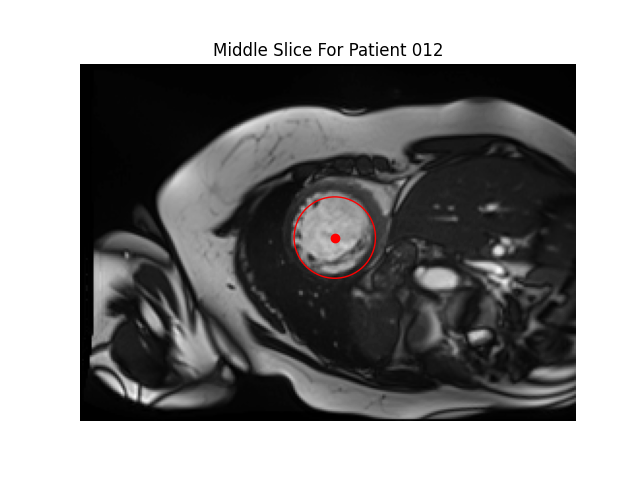

In [88]:
irm=Irm("012")
values = new_hough(irm)
x = np.median([val[0] for val in values])
y = np.median([val[1] for val in values])
initial_seed_point = [(int(x),int(y))]
print(initial_seed_point)
plt.figure(1)
fig, ax = plt.subplots()
ax.imshow(irm.data[0,:,:,irm.middle_slice], cmap='gray')

# Plot the seed point in red
ax.plot(initial_seed_point[0][1], initial_seed_point[0][0], 'ro')

# Plot the circle in red
circle = plt.Circle((initial_seed_point[0][1], initial_seed_point[0][0]), 21, color='r', fill=False)
ax.add_patch(circle)

plt.title('Middle Slice For Patient 012')
plt.axis('off')
plt.show()

##### Principal Function

In [38]:
def step_1(irm,maladie='HCM',show=False,filtered=False):
    if int(irm.patient_id) < 101:
        pass
    elif 100 < int(irm.patient_id) < 151:
        pass
    else:
        print("Patient ID must be between 001 et 150.")
        return
    
    temporary_dictionnary = {} #used to store slicez in the right order
    data = irm.data
    middle_slice_index = irm.middle_slice
    
    working_set = absolute_difference_Ed_ES(irm.patient_id,irm.middle_slice).astype('uint8')

    std = np.std(working_set)
    if std < 10:
        lowThresh = 15*std
    elif 10 <= std < 26:
        lowThresh = 20*std
    else:
        lowThresh = 15*std 
    edges = cv2.Canny(working_set, lowThresh, 1.5*lowThresh)
    initial_seed_point = [hough(edges)]
    if len(initial_seed_point) > 1:
        raise ValueError(f"Plusieurs cercles detectes : {len(initial_seed_point)}")

    t_ED = irm.t_ED
    t_ES = irm.t_ES
    irm.seed_points={(t_ED,middle_slice_index):initial_seed_point[0],(t_ES,middle_slice_index):initial_seed_point[0]}
    center_y,center_x=irm.seed_points[(t_ED,middle_slice_index)]

    to_process=[(t_ED,middle_slice_index),(t_ED,middle_slice_index+1),(t_ED,middle_slice_index-1)]
    while to_process:
        current_time, current_slice = to_process.pop(0)
        image_segmented,region = region_growing_adaptive(irm,current_time,center_y,center_x,current_slice,threshold=20,filtered=filtered, nb_neighbours=4)

        image_segmented[center_y,center_x] = [0,0,255,255]
        image_segmented[center_y,center_x+1] = [0,0,255,255]
        image_segmented[center_y+1,center_x] = [0,0,255,255]
        image_segmented[center_y,center_x-1] = [0,0,255,255]
        image_segmented[center_y-1,center_x] = [0,0,255,255]

        temporary_dictionnary[(current_time,current_slice)] = image_segmented

        min_energy_pixel = barycentre(irm,current_time, current_slice, region)
        irm.seed_points[(current_time,current_slice)]=min_energy_pixel
        center_x,center_y=min_energy_pixel
        image_segmented[center_y,center_x] = [255,0,0,255]

        if current_slice+1<data.shape[-1] and (current_time,current_slice+1) not in irm.seed_points:
            to_process.append((current_time,current_slice+1))
        if current_slice-1>=0 and (current_time,current_slice-1) not in irm.seed_points:
            to_process.append((current_time,current_slice-1))
    for k in range(irm.data.shape[-1]):
        irm.images_processed.append(temporary_dictionnary[(t_ED,k)])
    if show:
        images_to_plot = np.array(irm.images_processed)  
        bulk_plot(images_to_plot)
    return

##### Example of use of the principal function

In [39]:
#irm=Irm("093")
#step_1(irm,filtered=True,show=True);

### Metrics

In [40]:
def binary(image):
    im = np.zeros((image.shape[0],image.shape[1]))
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if (image[x,y] == [0,128,0]).all() or (image[x,y] == [0,0,255]).all():
                im[x,y] = 1
            else:
                pass
    return im

def dice_coefficient(image1,image2,show=False):
    image2 = image2 > 2.
    intersection = np.logical_and(image1,image2)
    diff = image1-image2
    if show:
        fig, axs = plt.subplots(1,4 , figsize=(15, 5))
        axs[0].imshow(image1, cmap='gray')
        axs[0].set_title('Image 1')
        axs[0].axis('off')

        axs[1].imshow(image2, cmap='gray')
        axs[1].set_title('Image 2')
        axs[1].axis('off')

        axs[2].imshow(intersection, cmap='gray')
        axs[2].set_title('Intersection')
        axs[2].axis('off')

        axs[3].imshow(diff, cmap='gray')
        axs[3].set_title('Difference between our segmentation and real segmentation')
        axs[3].axis('off')
        plt.show()
    return 2. * intersection.sum() / (image1.sum() + image2.sum())

def metrics(irm, e=None,show = False,write=True):
    id = irm.patient_id
    
    mean = 0
    predictions = []
    irm.images_processed = np.array(irm.images_processed)
    if e is not None:
        if str(e)[:26] == "Plusieurs cercles detectes":
            tmp_data = str(e)
        elif str(e) == "Too many iterations. Threshold is too high.":
            tmp_data = "Too many iterations. Threshold is too high."
        elif str(e) == "Coordinates are out of bounds.":
            tmp_data = "Coordinates are out of bounds."
        else:
            raise ValueError("Error not recognized.")
    else:
        tmp_data={}
        for k in range(irm.data.shape[-1]):
            predictions.append(binary(irm.images_processed[k,:,:]))
        gt1 = irm.gt1
        for k in range(gt1.shape[-1]):
            dice = dice_coefficient(predictions[k],gt1[0,:,:,k],show)
            tmp_data[f"Dice coefficient for slice {k}"] = f"{dice}"
            mean += dice
        mean /= gt1.shape[-1]
        tmp_data[f"Mean dice coefficient:"] = f"{mean}"
    if write:
        try:
            with open('test_logs.json', "r") as file:
                data = json.load(file)
        except FileNotFoundError:
        # Si le fichier n'existe pas, initialiser un tableau vide
            data = {}
        tmp_data["Group"]= irm.info["Group"]
        # Ajouter les nouvelles données
        data[str(id)] = tmp_data

        # Réécrire le fichier JSON avec les nouvelles données
        with open('test_logs.json', "w") as file:
            json.dump(data, file, indent=4)
    return mean

### Results

In [41]:
with open(f'test_logs.json', 'r') as file:
    data = json.load(file)

all_data = {}
all_errors = []

for k in range(1,101):
    k = str(k)
    if len(k)==1:
        k = '00'+str(k)
    elif len(k)==2:
        k = '0'+str(k)
    else:
        pass
    try:
        new_data = data[str(k)]
        #print(new_data)
        val = float(new_data['Mean dice coefficient:'])
        all_data[k] = [val, new_data['Group']]
    except:
        all_errors.append(k)


def plot_bar(all_data,type="all"):
    values = list(all_data.values())

    plt.figure(figsize=(10, 5))
    if type=="all":   
        plt.bar(all_data.keys(), [val[0] for val in values], color='blue')
        plt.title('Mean Dice Coefficient for Each Data Index')
    elif type=="NOR":
        filtered_data = {key: val for key, val in all_data.items() if val[1] == 'NOR'}
        values = list(filtered_data.values())
        plt.bar(filtered_data.keys(), [val[0] for val in filtered_data.values()], color='blue')
        plt.title('Mean Dice Coefficient for Each Data Index - NOR')
    elif type=="RV":
        filtered_data = {key: val for key, val in all_data.items() if val[1] == 'RV'}
        values = list(filtered_data.values())
        plt.bar(filtered_data.keys(), [val[0] for val in filtered_data.values()], color='blue')
        plt.title('Mean Dice Coefficient for Each Data Index - RV')
    elif type == "MINF" :
        filtered_data = {key: val for key, val in all_data.items() if val[1] == 'MINF'}
        values = list(filtered_data.values())
        plt.bar(filtered_data.keys(), [val[0] for val in filtered_data.values()], color='blue')
        plt.title('Mean Dice Coefficient for Each Data Index - MINF')
    elif type == "HCM":
        filtered_data = {key: val for key, val in all_data.items() if val[1] == 'HCM'}
        values = list(filtered_data.values())
        plt.bar(filtered_data.keys(), [val[0] for val in filtered_data.values()], color='blue')
        plt.title('Mean Dice Coefficient for Each Data Index - HCM')
    elif type == "DCM":
        filtered_data = {key: val for key, val in all_data.items() if val[1] == 'DCM'}
        values = list(filtered_data.values())
        plt.bar(filtered_data.keys(), [val[0] for val in filtered_data.values()], color='blue')
        plt.title('Mean Dice Coefficient for Each Data Index - DCM')
    plt.xlabel('Data Index')
    plt.ylabel('Mean Dice Coefficient')
    plt.xticks(rotation=90)
    plt.tight_layout()

    mean = np.mean([val[0] for val in values])
    print(f'Mean dice for {type}: ', mean)
    count = 0
    for val in values:
        if val[0] < 0.4:
            count += 1
    print(f'Number of means<0.4 in values: {count}\n')

In [42]:
""" plot_bar(all_data, type="all")
plot_bar(all_data, type="DCM")
plot_bar(all_data, type="HCM")
plot_bar(all_data, type="MINF")
plot_bar(all_data, type="NOR")
plot_bar(all_data, type="RV")

plt.show() """


' plot_bar(all_data, type="all")\nplot_bar(all_data, type="DCM")\nplot_bar(all_data, type="HCM")\nplot_bar(all_data, type="MINF")\nplot_bar(all_data, type="NOR")\nplot_bar(all_data, type="RV")\n\nplt.show() '